In [1]:
import bs4
from urllib.request import urlopen

In [2]:
url_float = 'http://companyinfo.stock.naver.com/v1/company/c1010001.aspx?cmp_cd=035420'     
# Floating ratio from Naver
url_float

'http://companyinfo.stock.naver.com/v1/company/c1010001.aspx?cmp_cd=035420'

In [3]:
source = urlopen(url_float).read()
soup = bs4.BeautifulSoup(source, 'lxml')

//*[@id="cTB11"]/tbody/tr[7]/td

In [4]:
soup.find(id='cTB11').find_all('tr')[6].td.text

'\r\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t164,813,395주 / 78.70%\r\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t'

In [5]:
tmp = soup.find(id='cTB11').find_all('tr')[6].td.text
tmp = tmp.replace('\r', '')
tmp = tmp.replace('\n', '')
tmp = tmp.replace('\t', '')
tmp

'164,813,395주 / 78.70%'

In [6]:
import re

In [7]:
tmp = re.split('/', tmp)
tmp

['164,813,395주 ', ' 78.70%']

In [8]:
tmp[0]

'164,813,395주 '

In [9]:
tmp[1]

' 78.70%'

In [10]:
outstanding = tmp[0].replace(',', '')
outstanding = outstanding.replace('주', '')
outstanding = outstanding.replace(' ', '')
outstanding

'164813395'

In [11]:
floating = tmp[1].replace(' ', '')
floating = floating.replace('%', '')
floating

'78.70'

In [12]:
outstanding = int(outstanding)
outstanding

164813395

In [13]:
floating = float(floating)
floating

78.7

In [14]:
# 구성종목 기본정보
def stock_info(stock_cd):
    url_float = 'http://companyinfo.stock.naver.com/v1/company/c1010001.aspx?cmp_cd=' + stock_cd
    source = urlopen(url_float).read()
    soup = bs4.BeautifulSoup(source, 'lxml')
    
    tmp = soup.find(id='cTB11').find_all('tr')[6].td.text
    tmp = tmp.replace('\r', '')
    tmp = tmp.replace('\n', '')
    tmp = tmp.replace('\t', '')
    
    tmp = re.split('/', tmp)

    outstanding = tmp[0].replace(',', '')
    outstanding = outstanding.replace('주', '')
    outstanding = outstanding.replace(' ', '')
    outstanding = int(outstanding)

    floating = tmp[1].replace(' ', '')
    floating = floating.replace('%', '')
    floating = float(floating)
    
    name = soup.find(id='pArea').find('div').find('div').find('tr').find('td').find('span').text
    
    k10_outstanding[stock_cd] = outstanding
    k10_floating[stock_cd] = floating
    k10_name[stock_cd] = name

In [15]:
'''
한국거래소 시가총액 상위 10종목 (2019년1월 기준)
005930	삼성전자
000660	SK하이닉스
068270	셀트리온
005380	현대차
207940	삼성바이오로직스
051910	LG화학
005490	POSCO
035420	NAVER
017670	SK텔레콤
015760	한국전력
'''
k10_component = ['005930', '000660', '068270', '005380', '207940',\
                 '051910', '005490', '035420', '017670', '015760']

In [16]:
k10_outstanding = dict()
k10_floating = dict()
k10_name = dict()
for stock_cd in k10_component:
    print(stock_cd)
    stock_info(stock_cd)

005930
000660
068270
005380
207940
051910
005490
035420
017670
015760


In [17]:
k10_outstanding

{'005930': 5969782550,
 '000660': 728002365,
 '068270': 127948184,
 '005380': 213668187,
 '207940': 66165000,
 '051910': 70592343,
 '005490': 87186835,
 '035420': 164813395,
 '017670': 80745711,
 '015760': 641964077}

In [18]:
k10_floating

{'005930': 78.75,
 '000660': 73.89,
 '068270': 66.35,
 '005380': 66.33,
 '207940': 24.76,
 '051910': 64.28,
 '005490': 79.6,
 '035420': 78.7,
 '017670': 62.23,
 '015760': 48.86}

과거 주가 구하기 

In [19]:
import datetime as dt
import pandas as pd

In [20]:
def date_format(d):
    d = str(d).replace('-', '.')
    
    yyyy = int(d.split('.')[0]) 
    mm = int(d.split('.')[1])
    dd = int(d.split('.')[2])

    this_date= dt.date(yyyy, mm, dd)
    return this_date

In [21]:
def historical_stock_naver(stock_cd, start_date='', end_date='', page_n=1, last_page=0):
    
    if start_date:   # start_date가 있으면
        start_date = date_format(start_date)   # date 포맷으로 변환
    else:    # 없으면
        start_date = dt.date.today()   # 오늘 날짜를 지정
    if end_date:   # end_date가 없으면 
        end_date = date_format(end_date)   # date 포맷으로 변환
    else:   # end_date가 있으면
        end_date = dt.date.today()   # 오늘 날짜를 end_date로 지정
        
    naver_stock = 'http://finance.naver.com/item/sise_day.nhn?code=' + stock_cd + '&page=' + str(page_n)
    
    source = urlopen(naver_stock).read()
    source = bs4.BeautifulSoup(source, 'lxml')
    
    dates = source.find_all('span', class_='tah p10 gray03')   # 날짜 수집   
    prices = source.find_all('td', class_='num')   # 종가 수집
    
    for n in range(len(dates)):
    
        if len(dates) > 0:
            
            # 날짜 처리
            this_date = dates[n].text
            this_date = date_format(this_date)
            
            if this_date <= end_date and this_date >= start_date:   
            # start_date와 end_date 사이에서 데이터 저장
                # 종가 처리
                this_close = prices[n*6].text
                this_close = this_close.replace(',', '')
                this_close = float(this_close)

                # 딕셔너리에 저장
                historical_prices[this_date] = this_close
                              
            elif this_date < start_date:   
            # start_date 이전이면 함수 종료
                return historical_prices              
            
    # 페이지 네비게이션
    if last_page == 0:
        last_page = source.find_all('table')[1].find('td', class_='pgRR').find('a')['href']
        last_page = last_page.split('&')[1]
        last_page = last_page.split('=')[1]
        last_page = float(last_page)
        
    # 다음 페이지 호출
    if page_n < last_page:
        page_n = page_n + 1
        historical_stock_naver(stock_cd, start_date, end_date, page_n, last_page)   
        
    return historical_prices  

In [22]:
k10_historical_prices = dict()

for stock_cd in k10_component:
    
    historical_prices = dict()
    start_date = '2017-1-1'
    end_date = '2017-12-31'
    historical_stock_naver(stock_cd, start_date, end_date)
    
    k10_historical_prices[stock_cd] = historical_prices

In [23]:
k10_historical_price = pd.DataFrame(k10_historical_prices)
k10_historical_price.sort_index(axis=1, inplace=True) 

In [24]:
k10_historical_price = k10_historical_price.fillna(method='ffill')   # ffill로 구멍을 채우고
if k10_historical_price.isnull().values.any():   # 그래도 구멍이 남아 있으면
    k10_historical_price = k10_historical_price.fillna(method='bfill')   # bfill로 채워라
k10_historical_price.head(3)

,000660,005380,005490,005930,015760,017670,035420,051910,068270,207940
2017-01-02,45800.0,150000.0,260500.0,1805000.0,43900.0,225500.0,777000.0,253000.0,108200.0,156500.0
2017-01-03,47250.0,153000.0,256000.0,1824000.0,44100.0,223000.0,767000.0,262000.0,106600.0,158000.0
2017-01-04,46500.0,154000.0,254500.0,1808000.0,43900.0,223000.0,810000.0,268500.0,106100.0,154500.0


In [25]:
k10_historical_price['005930'] = k10_historical_price['005930'] / 50   # 삼성전자 액면분할에 따른 수정주가 계산
k10_historical_price.head(3)

,000660,005380,005490,005930,015760,017670,035420,051910,068270,207940
2017-01-02,45800.0,150000.0,260500.0,36100.0,43900.0,225500.0,777000.0,253000.0,108200.0,156500.0
2017-01-03,47250.0,153000.0,256000.0,36480.0,44100.0,223000.0,767000.0,262000.0,106600.0,158000.0
2017-01-04,46500.0,154000.0,254500.0,36160.0,43900.0,223000.0,810000.0,268500.0,106100.0,154500.0


지수 산출을 위한 계산

In [26]:
tmp = {'Outstanding' : k10_outstanding,\
       'Floating' : k10_floating,\
       'Price' : k10_historical_price.iloc[0],\
       'Name' : k10_name}
k10_info = pd.DataFrame(tmp)

In [27]:
k10_info['f Market Cap'] = k10_info['Outstanding'] * k10_info['Floating'] * k10_info['Price'] * 0.01
k10_info['Market Cap'] = k10_info['Outstanding'] * k10_info['Price'] * 0.01
k10_info

,Outstanding,Floating,Price,Name,f Market Cap,Market Cap
000660,728002365,73.89,45800.0,SK하이닉스,2.463678e+13,3.334251e+11
005380,213668187,66.33,150000.0,현대차,2.125892e+13,3.205023e+11
005490,87186835,79.60,260500.0,POSCO,1.807889e+13,2.271217e+11
005930,5969782550,78.75,36100.0,삼성전자,1.697135e+14,2.155092e+12
015760,641964077,48.86,43900.0,한국전력,1.376983e+13,2.818222e+11
017670,80745711,62.23,225500.0,SK텔레콤,1.133094e+13,1.820816e+11
035420,164813395,78.70,777000.0,NAVER,1.007832e+14,1.280600e+12
051910,70592343,64.28,253000.0,LG화학,1.148032e+13,1.785986e+11
068270,127948184,66.35,108200.0,셀트리온,9.185490e+12,1.384399e+11
207940,66165000,24.76,156500.0,삼성바이오로직스,2.563854e+12,1.035482e+11


In [28]:
k10_historical_mc = k10_historical_price * k10_info['Outstanding'] * k10_info['Floating'] * 0.01
k10_historical_mc.head(3)

,000660,005380,005490,005930,015760,017670,035420,051910,068270,207940
2017-01-02,2.463678e+13,2.125892e+13,1.807889e+13,1.697135e+14,1.376983e+13,1.133094e+13,1.007832e+14,1.148032e+13,9.185490e+12,2.563854e+12
2017-01-03,2.541676e+13,2.168409e+13,1.776658e+13,1.714999e+14,1.383257e+13,1.120532e+13,9.948614e+13,1.188871e+13,9.049660e+12,2.588428e+12
2017-01-04,2.501332e+13,2.182582e+13,1.766248e+13,1.699955e+14,1.376983e+13,1.120532e+13,1.050636e+14,1.218366e+13,9.007213e+12,2.531089e+12


In [29]:
'''
<데이터프레임>.sum() 은 각 열의 합 (세로방향)
<데이터프레임>.sum(axis=1) 은 각 행의 합 (가로방향)
'''
k10_historical_mc.sum(axis=1)     # 일자별 시가총액 합

2017-01-02    3.828017e+14
2017-01-03    3.844182e+14
2017-01-04    3.882579e+14
2017-01-05    3.830483e+14
2017-01-06    3.872106e+14
2017-01-09    3.891833e+14
2017-01-10    3.914117e+14
2017-01-11    3.997941e+14
2017-01-12    4.025977e+14
2017-01-13    3.948536e+14
2017-01-16    3.907427e+14
2017-01-17    3.924462e+14
2017-01-18    3.909576e+14
2017-01-19    3.957714e+14
2017-01-20    3.914607e+14
2017-01-23    3.938119e+14
2017-01-24    3.932145e+14
2017-01-25    3.983605e+14
2017-01-26    4.014118e+14
2017-01-31    3.988460e+14
2017-02-01    3.999225e+14
2017-02-02    3.997122e+14
2017-02-03    4.008430e+14
2017-02-06    4.015577e+14
2017-02-07    4.013025e+14
2017-02-08    3.988315e+14
2017-02-09    3.970542e+14
2017-02-10    3.978227e+14
2017-02-13    3.964866e+14
2017-02-14    3.901352e+14
                  ...     
2017-11-16    5.228721e+14
2017-11-17    5.237160e+14
2017-11-20    5.195293e+14
2017-11-21    5.227476e+14
2017-11-22    5.256822e+14
2017-11-23    5.228240e+14
2

In [30]:
k10 = pd.DataFrame()
k10['K10 Market Cap'] = k10_historical_mc.sum(axis=1)
k10.head(3)

,K10 Market Cap
2017-01-02,3.828017e+14
2017-01-03,3.844182e+14
2017-01-04,3.882579e+14


In [31]:
k10['K10'] = k10['K10 Market Cap'] / k10['K10 Market Cap'][0] * 100
k10.head(3)

,K10 Market Cap,K10
2017-01-02,3.828017e+14,100.000000
2017-01-03,3.844182e+14,100.422277
2017-01-04,3.882579e+14,101.425324


K10 지수 그래프 그리기

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

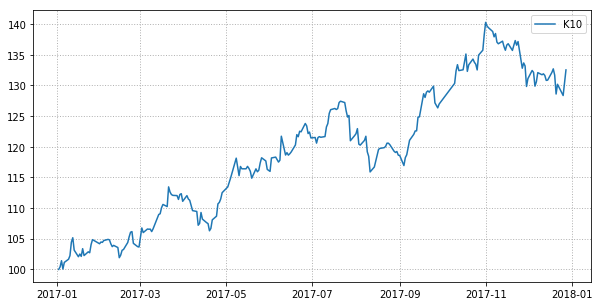

In [33]:
plt.figure(figsize=(10, 5))
plt.plot(k10['K10'])
plt.legend(loc=0)
plt.grid(True, color='0.7', linestyle=':', linewidth=1)

KOSPI200과의 비교

In [34]:
def historical_index_naver(index_cd, start_date='', end_date='', page_n=1, last_page=0):
    
    index_cd = index_cd   # 인덱스 코드 
    page_n = page_n   # 페이지 번호 
    
    if start_date:   # start_date가 있으면
        start_date = date_format(start_date)   # date 포맷으로 변환
    else:    # 없으면
        start_date = dt.date.today()   # 오늘 날짜를 지정
    if not end_date:   # end_date가 없으면 
        end_date = dt.date.today()   # 오늘 날짜를 end_date로 지정
    else:   # end_date가 있으면
        end_date = date_format(end_date)   # date 포맷으로 변환
        
    naver_index = 'http://finance.naver.com/sise/sise_index_day.nhn?code=' + index_cd + '&page=' + str(page_n)
    
    source = urlopen(naver_index).read()   # 지정한 페이지에서 코드 읽기
    source = bs4.BeautifulSoup(source, 'lxml')   # 뷰티풀 스프로 태그별로 코드 분류
    
    dates = source.find_all('td', class_='date')   # <td class="date">태그에서 날짜 수집   
    prices = source.find_all('td', class_='number_1')   # <td class="number_1">태그에서 지수 수집
    
    for n in range(len(dates)):
    
        if dates[n].text.split('.')[0].isdigit():
            
            # 날짜 처리
            this_date = dates[n].text
            this_date= date_format(this_date)
            
            if this_date <= end_date and this_date >= start_date:   
            # start_date와 end_date 사이에서 데이터 저장
                # 종가 처리
                this_close = prices[n*4].text   # prices 중 종가지수인 0,4,8,...번째 데이터 추출
                this_close = this_close.replace(',', '')
                this_close = float(this_close)

                # 딕셔너리에 저장
                historical_prices[this_date] = this_close
                
            elif this_date < start_date:   
            # start_date 이전이면 함수 종료
                return historical_prices           
            
    # 페이지 네비게이션
    if last_page == 0:
        last_page = source.find('td', class_='pgRR').find('a')['href']
        # 마지막페이지 주소 추출
        last_page = last_page.split('&')[1]   # & 뒤의 page=506 부분 추출
        last_page = last_page.split('=')[1]   # = 뒤의 페이지번호만 추출
        last_page = int(last_page)   # 숫자형 변수로 변환
        
    # 다음 페이지 호출
    if page_n < last_page:   
        page_n = page_n + 1   
        historical_index_naver(index_cd, start_date, end_date, page_n, last_page)   
        
    return historical_prices  

In [35]:
historical_prices = dict()     # 딕셔너리 초기화
kospi200 = historical_index_naver('KPI200', '2017-1-1', '2017-12-31')
kospi200

{datetime.date(2017, 12, 28): 324.74,
 datetime.date(2017, 12, 27): 320.25,
 datetime.date(2017, 12, 26): 318.89,
 datetime.date(2017, 12, 22): 321.21,
 datetime.date(2017, 12, 21): 319.72,
 datetime.date(2017, 12, 20): 325.79,
 datetime.date(2017, 12, 19): 326.76,
 datetime.date(2017, 12, 18): 326.6,
 datetime.date(2017, 12, 15): 326.23,
 datetime.date(2017, 12, 14): 324.74,
 datetime.date(2017, 12, 13): 326.18,
 datetime.date(2017, 12, 12): 324.07,
 datetime.date(2017, 12, 11): 325.09,
 datetime.date(2017, 12, 8): 324.68,
 datetime.date(2017, 12, 7): 323.59,
 datetime.date(2017, 12, 6): 324.52,
 datetime.date(2017, 12, 5): 329.61,
 datetime.date(2017, 12, 4): 328.77,
 datetime.date(2017, 12, 1): 324.78,
 datetime.date(2017, 11, 30): 325.25,
 datetime.date(2017, 11, 29): 330.68,
 datetime.date(2017, 11, 28): 330.99,
 datetime.date(2017, 11, 27): 329.53,
 datetime.date(2017, 11, 24): 335.44,
 datetime.date(2017, 11, 23): 334.51,
 datetime.date(2017, 11, 22): 335.49,
 datetime.date(2017

In [36]:
k200 = pd.DataFrame({'K200' : kospi200})
k200.head(3)

,K200
2017-01-02,260.36
2017-01-03,262.97
2017-01-04,263.12


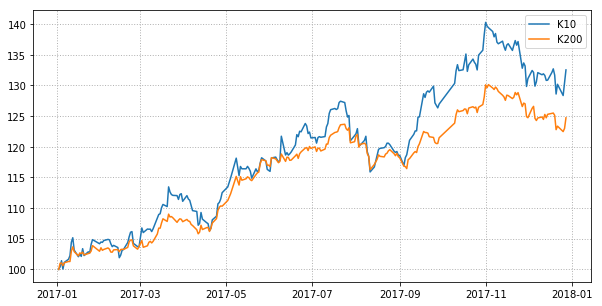

In [37]:
plt.figure(figsize=(10, 5))
plt.plot(k10['K10'] / k10['K10'][0] * 100)
plt.plot(k200['K200'] / k200['K200'][0] * 100)
plt.legend(loc=0)
plt.grid(True, color='0.7', linestyle=':', linewidth=1)

# K10 선물가격 산출

In [38]:
import math

F = Se^(r-d)t

In [39]:
def futures_price (S, r, d, T, t0):
    t = (T - t0).days / 252
    F = S * math.exp((r-d)*t)
    return F

In [40]:
T = dt.date(2018, 12, 14)     # 만기일
t0 = dt.date(2018, 6, 15)     # 현재일

futures_price (100.0, 0.02, 0.015, T, t0)

100.36176390281524

In [41]:
T = dt.date(2018, 12, 14)     # 만기일
t0 = dt.date(2018, 12, 10)     # 현재일

futures_price (100.0, 0.02, 0.015, T, t0)

100.00793682288563